<a href="https://colab.research.google.com/github/Vasanta2002/Sprint_5/blob/main/JDS_SHR_213_guided_project_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BloomTech Data Science

---


# Ridge Regression
- Do one-hot encoding of categorical features
- Use scikit-learn to fit Ridge Regression models



In [1]:
# Model Building

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For running this notebook either locally or in colab
import sys

In [2]:
%%capture
# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/bloominstituteoftechnology/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [3]:
# For encoding categorical data
from category_encoders import OneHotEncoder

# I. Wrangle Data

Create **wrangle function** for **reproducibility**.

In [4]:
def wrangle(filepath):
  df = pd.read_csv(filepath,
                   parse_dates = ['created'], 
                   index_col='created').sort_index()

  # Remove outlier observations
  df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
          (df['price'] <= np.percentile(df['price'], 99.5)) & 
          (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
          (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
          (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
          (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

  # Drop high-cardinality categorical variables
  cutoff = 90
  drop_cols = [col for col in df.select_dtypes('object').columns 
              if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

  return df

df = wrangle(DATA_PATH+'apartments/renthop-nyc.csv')

In [5]:
df.shape

(48817, 30)

In [6]:
df.head()

,bathrooms,bedrooms,latitude,longitude,price,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,...,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,
2016-04-01 22:12:41,1.0,1,40.7302,-73.9924,3195,high,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-04-01 22:56:00,1.0,0,40.7576,-73.9677,2000,medium,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2016-04-01 22:57:15,2.0,3,40.7388,-73.9851,5850,high,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1
2016-04-01 23:26:07,1.0,1,40.7939,-73.9738,2745,medium,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1
2016-04-02 00:48:13,1.0,1,40.7784,-73.9491,2400,medium,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48817 entries, 2016-04-01 22:12:41 to 2016-06-29 21:41:47
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bathrooms             48817 non-null  float64
 1   bedrooms              48817 non-null  int64  
 2   latitude              48817 non-null  float64
 3   longitude             48817 non-null  float64
 4   price                 48817 non-null  int64  
 5   interest_level        48817 non-null  object 
 6   elevator              48817 non-null  int64  
 7   cats_allowed          48817 non-null  int64  
 8   hardwood_floors       48817 non-null  int64  
 9   dogs_allowed          48817 non-null  int64  
 10  doorman               48817 non-null  int64  
 11  dishwasher            48817 non-null  int64  
 12  no_fee                48817 non-null  int64  
 13  laundry_in_building   48817 non-null  int64  
 14  fitness_center        48817 non-nul

In [8]:
df.isnull().sum()

bathrooms               0
bedrooms                0
latitude                0
longitude               0
price                   0
interest_level          0
elevator                0
cats_allowed            0
hardwood_floors         0
dogs_allowed            0
doorman                 0
dishwasher              0
no_fee                  0
laundry_in_building     0
fitness_center          0
pre-war                 0
laundry_in_unit         0
roof_deck               0
outdoor_space           0
dining_room             0
high_speed_internet     0
balcony                 0
swimming_pool           0
new_construction        0
terrace                 0
exclusive               0
loft                    0
garden_patio            0
wheelchair_access       0
common_outdoor_space    0
dtype: int64

In [9]:
# threshold = 10
# cols_to_drop = []
# for col in df:
#   if df[col].dtype == 'object':
#     if df[col].nunique() > threshold:
#       cols_to_drop.append(col)

# df.drop(columns=cols_to_drop, inplace=True)

In [10]:
  # cutoff = 90
  # drop_cols = [col for col in df.select_dtypes('object').columns 
  #             if df[col].nunique() > cutoff]
  # df.drop(columns=drop_cols, inplace=True)

# II. Split Data

Split **target vector** from **feature matrix**.

In [11]:
target = 'price'
y = df[target]
X = df.drop(columns=target)

Split data into **training** and **test** sets.

(Use data from April & May 2016 to train. Use data from June 2016 to test.)

In [12]:
X.index.max(), X.index.min()

(Timestamp('2016-06-29 21:41:47'), Timestamp('2016-04-01 22:12:41'))

In [13]:
# Several masks to choose from

# mask = X.index.month == 4 | (X.index.month == 5)
# mask = Xindex.month <  6


In [14]:
# or apply the mask based on cut-off given below
cutoff = '2016-06-01'

mask = X.index < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

In [15]:
X_train.shape, y_train.shape

((31844, 29), (31844,))

In [16]:
X_test.shape, y_test.shape

((16973, 29), (16973,))

# III. Establish Baseline

In [17]:
y_pred = [y_train.mean()] * len(y_train)
print('Mean price:', y_train.mean())
print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Mean price: 3575.604007034292
Baseline MAE: 1201.8811133682555


# IV. Build Models

In [18]:
# Step 1: Import your transformer class
# We did above ☝️

# Step 2: Insantiate your transformer
ohe = OneHotEncoder(use_cat_names=True)
# Step 3: Fit your transformer
ohe.fit(X_train)
# Step 4: Transform 
XT_train = ohe.transform(X_train)
XT_test = ohe.transform(X_test)

In [19]:
XT_train.head()

,bathrooms,bedrooms,latitude,longitude,interest_level_high,interest_level_medium,interest_level_low,elevator,cats_allowed,hardwood_floors,...,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,
2016-04-01 22:12:41,1.0,1,40.7302,-73.9924,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-04-01 22:56:00,1.0,0,40.7576,-73.9677,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2016-04-01 22:57:15,2.0,3,40.7388,-73.9851,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
2016-04-01 23:26:07,1.0,1,40.7939,-73.9738,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
2016-04-02 00:48:13,1.0,1,40.7784,-73.9491,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


**Model 1:** Regular ol' linear regression

In [20]:
model_lr = LinearRegression()
model_lr.fit(XT_train, y_train)

LinearRegression()

**Model 2:** Ridge regression (regularization)

In [21]:
model_r = Ridge(alpha = 1.0) #hyper parameter
model_r.fit(XT_train, y_train)

Ridge()

# V. Check Metrics

In [22]:
print('LR training MAE:', mean_absolute_error(y_train, model_lr.predict(XT_train))) 
print('LR test MAE:', mean_absolute_error(y_test, model_lr.predict(XT_test)))

LR training MAE: 673.159672936817
LR test MAE: 676.1164275614211


In [23]:
print('Ridge training MAE:', mean_absolute_error(y_train, model_r.predict(XT_train)))
print('Ridge test MAE:', mean_absolute_error(y_test, model_r.predict(XT_test)))

Ridge training MAE: 672.664072658999
Ridge test MAE: 675.5149089564139


# Communicate results

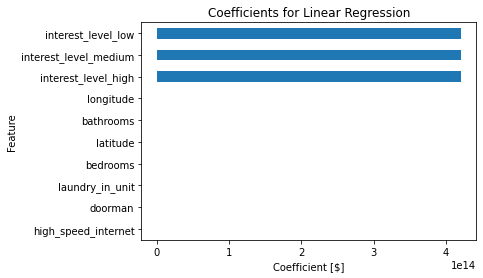

In [27]:
coefficients = model_lr.coef_
features = ohe.get_feature_names()

feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(10).plot(kind='barh')

plt.xlabel('Coefficient [$]')
plt.ylabel('Feature')
plt.title('Coefficients for Linear Regression');

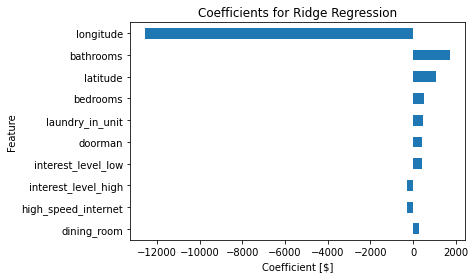

In [25]:
coefficients = model_r.coef_
features = ohe.get_feature_names()


feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(10).plot(kind='barh')

plt.xlabel('Coefficient [$]')
plt.ylabel('Feature')
plt.title('Coefficients for Ridge Regression');


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


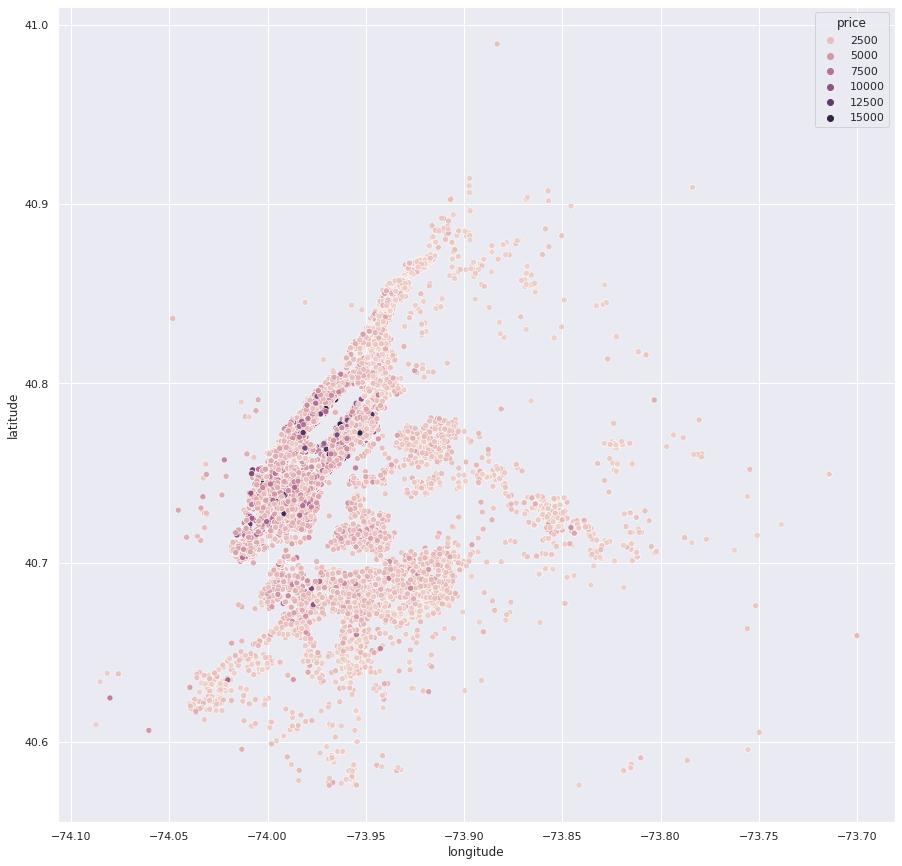

In [26]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,15)})
sns.scatterplot('longitude', 'latitude', hue='price', data=df);